In [19]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci,ppi_ols_pointestimate
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq  
from sklearn.linear_model import Ridge
from tqdm import tqdm
from utils import *

In [20]:
def generate_data(
    n_total: int,
    p: int,
    N_model: int,
    std: float = 1.0,
    theta: np.ndarray = None,
    random_state: int = None
):
    rng = np.random.RandomState(random_state)

    # 1) Generate theta if not provided
    if theta is None:
        theta = rng.uniform(low=-1.0, high=1.0, size=p) # * 100
        # theta = theta / np.linalg.norm(theta)
    
    # 2) Generate total data
    X_total = rng.normal(size=(n_total, p))
    noise_eval = std * rng.normal(size=n_total)

    Y_total = X_total @ theta + noise_eval

    # 3) Generate predictions
    X_model = rng.normal(size=(N_model, p))
    noise_model = std * rng.normal(size=N_model)
    Y_model = X_model @ theta + noise_model

    model = OLS(Y_model, X_model).fit()
    Y_hat = model.predict(X_total)

    return X_total, Y_total, Y_hat, theta, X_total @ theta

In [21]:
# Set global parameters
ratios = [0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 5.0]
std_list =  [0.1, 1.0, 5.0, 10.0]
ns = [10, 20, 50, 100] 
ps = [20, 50, 100, 200]
rng = np.random.RandomState()

# num_trials = 10
alpha = 0.05

# Fix n and change p

In [16]:
from ppi_py import ppi_ols_pointestimate, classical_ols_ci
n_total = 5000
n = 100
num_trials = 30
ps = [10, 20, 50, 100, 200, 500, 1000]

results0 = []
for p in ps:
    print(f"Running experiments for p={p}...")
    _X_total, _Y_total, Yhat_total, theta, _ = generate_data(n_total, p, N_model= 2000, std=1.0)
    for trial in range(num_trials):
        idx = np.random.permutation(n_total)
        X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
        Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
        Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

        # PPI
        try:
            ppi_point = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=1)
            ppi_error = (ppi_point-theta)**2

            results0.append({ 
                "method": "PPI", "p": p, "n": n,
                "theta": theta.mean(),
                "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
            })

        except Exception as e:
            print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
            break

        # Classical
        try:
            classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
            classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
            classical_error = (classical_mid - theta) ** 2

            results0.append({
                "method": "Classical", "p": p, "n": n,
                "trial": trial, "std": 1.0,
                "theta": theta.mean(),
                "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
            })

        except Exception as e:
            print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
            break

df = pd.DataFrame(results0)
df.to_csv("experiment_results_lam1.csv", index=False)

Running experiments for p=10...
[Classical ERROR] p=10, trial=0: name 'alpha' is not defined
Running experiments for p=20...
[Classical ERROR] p=20, trial=0: name 'alpha' is not defined
Running experiments for p=50...
[Classical ERROR] p=50, trial=0: name 'alpha' is not defined
Running experiments for p=100...
[Classical ERROR] p=100, trial=0: name 'alpha' is not defined
Running experiments for p=200...
[Classical ERROR] p=200, trial=0: name 'alpha' is not defined
Running experiments for p=500...
[Classical ERROR] p=500, trial=0: name 'alpha' is not defined
Running experiments for p=1000...
[Classical ERROR] p=1000, trial=0: name 'alpha' is not defined


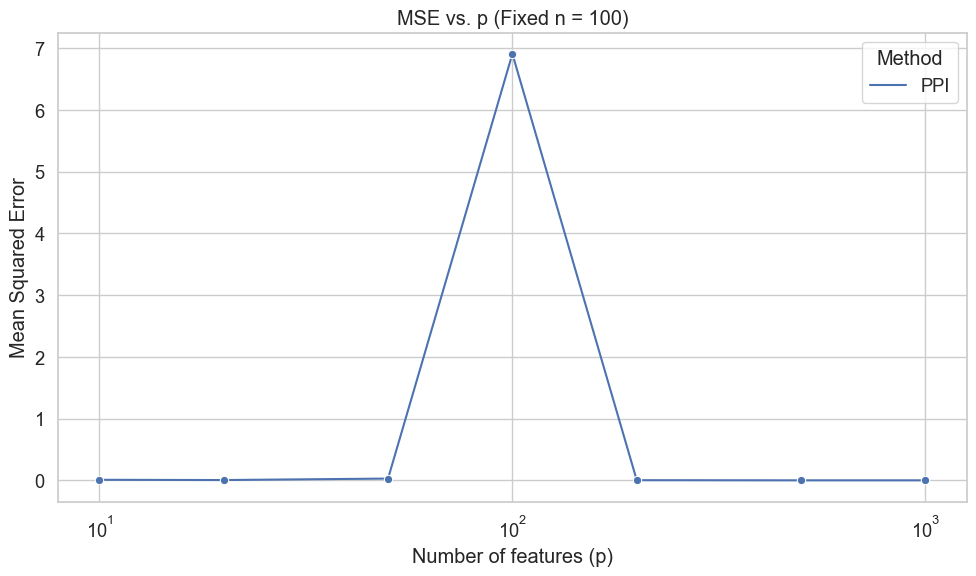

In [17]:
df = pd.read_csv("experiment_results_lam1.csv")
# df_avg = df[df["p"]!=100].groupby(["method", "p"])["error"].mean().reset_index()
df_avg = df.groupby(["method", "p"])["error"].mean().reset_index()

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_avg, x="p", y="error", hue="method", marker="o")

plt.title("MSE vs. p (Fixed n = 100)")
plt.xlabel("Number of features (p)")
plt.ylabel("Mean Squared Error")
plt.xscale("log")
plt.grid(True)
plt.legend(title="Method")
plt.tight_layout()
plt.show()

In [18]:
from ppi_py import ppi_ols_pointestimate, classical_ols_ci
n_total = 50000
n = 1000
num_trials = 10
# ps = np.linspace(50, 10000, 10).astype(int) 
ps = [50, 100, 200, 500, 800, 1000, 2000, 3000, 4000, 5000, 8000, 10000]

results1 = []
for p in ps:
    print(f"Running experiments for p={p}...")
    _X_total, _Y_total, Yhat_total, theta, _ = generate_data(n_total, p, N_model= 2000, std=1.0, random_state=1)
    for trial in range(num_trials):
        idx = np.random.permutation(n_total)
        X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
        Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
        Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]


        # PPI
        try:
            ppi_point = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=1)
            ppi_error = (ppi_point-theta)**2

            results1.append({ 
                "method": "PPI", "p": p, "n": n, #"ratio": ratio, 
                "trial": trial, "std": 1.0,
                "theta": theta.mean(),
                "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
            })

        except Exception as e:
            print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
            break

        # Classical
        try:
            classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
            classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
            classical_error = (classical_mid - theta) ** 2

            results1.append({
                "method": "Classical", "p": p, "n": n, #"ratio": ratio, 
                "trial": trial, "std": 1.0,
                # "lower": classical_ci[0].mean(), "upper": classical_ci[1].mean(), "coverage": classical_cover, 
                # "width": classical_width.mean(), "width_max": classical_width.max(), "width_min": classical_width.min(),
                "theta": theta.mean(),
                "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
            })

        except Exception as e:
            print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
            break

df5 = pd.DataFrame(results1)
df5.to_csv("experiment_results5_lam1_ver2.csv", index=False)

Running experiments for p=50...
[Classical ERROR] p=50, trial=0: name 'alpha' is not defined
Running experiments for p=100...
[Classical ERROR] p=100, trial=0: name 'alpha' is not defined
Running experiments for p=200...
[Classical ERROR] p=200, trial=0: name 'alpha' is not defined
Running experiments for p=500...
[Classical ERROR] p=500, trial=0: name 'alpha' is not defined
Running experiments for p=800...
[Classical ERROR] p=800, trial=0: name 'alpha' is not defined
Running experiments for p=1000...
[Classical ERROR] p=1000, trial=0: name 'alpha' is not defined
Running experiments for p=2000...


KeyboardInterrupt: 

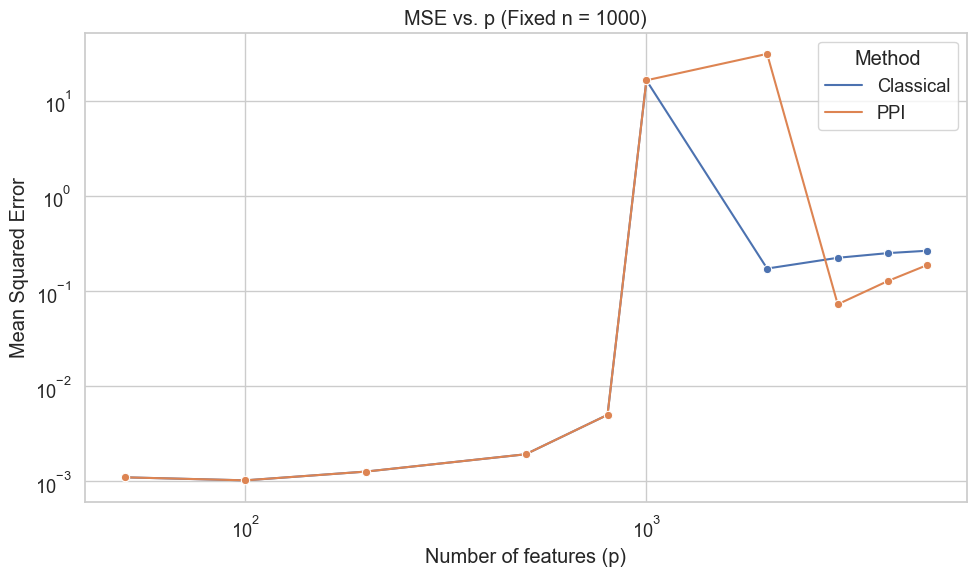

In [ ]:
#df0 = pd.read_csv("experiment_results0.csv")
#df5 = pd.read_csv("experiment_results5.csv")
#df_combined = pd.concat([df0[df0["p"]!=1000], df5[df5["p"]!=1155]], ignore_index=True)
# df_combined = pd.concat([df0, df5], ignore_index=True)
# df_combined["error"] = df_combined["error"]*df_combined["p"]

#df_avg = df_combined.groupby(["method", "p"])["error"].mean().reset_index()

df5 = pd.read_csv("experiment_results5_lam1.csv")
# df_avg = df5[(df5["p"] != 1000) & (df5["p"] != 2000) & (df5["p"]<=5000) ].groupby(["method", "p"])["error"].mean().reset_index()
df_avg = df5[(df5["p"]<=5000) ].groupby(["method", "p"])["error"].mean().reset_index()

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_avg, x="p", y="error", hue="method", marker="o")

plt.title("MSE vs. p (Fixed n = 1000)")
plt.xlabel("Number of features (p)")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.xscale("log")  
plt.grid(True)
plt.legend(title="Method")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from ppi_py import ppi_ols_pointestimate, classical_ols_ci

def run_experiment_varying_n(
    p=500,
    ns=[10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    n_total=50000,
    num_trials=10,
    std=1.0,
    lam=1.0,
    alpha=0.05,
    filename="experiment_results.csv",
    random_state=42
):
    results = []
    
    # Generate data once
    X_total, Y_total, Yhat_total, theta, _ = generate_data(
        n_total=n_total,
        p=p,
        N_model=2000,
        std=std,
        random_state=random_state
    )

    for n in ns:
        print(f"Running experiments for n={n}...")
        for trial in range(num_trials):
            idx = np.random.permutation(n_total)
            X_labeled, X_unlabeled = X_total[idx[:n]], X_total[idx[n:]]
            Y_labeled, Y_unlabeled = Y_total[idx[:n]], Y_total[idx[n:]]
            Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

            # --- PPI ---
            try:
                ppi_point = ppi_ols_pointestimate(
                    X_labeled, Y_labeled, Yhat_labeled,
                    X_unlabeled, Yhat_unlabeled,
                    lam=lam
                )
                ppi_error = (ppi_point - theta) ** 2
                results.append({
                    "method": "PPI", "p": p, "n": n, "trial": trial, "std": std,
                    "theta": theta.mean(),
                    "error": ppi_error.mean(),
                    "error_max": ppi_error.max(),
                    "error_min": ppi_error.min()
                })
            except Exception as e:
                print(f"[PPI ERROR] n={n}, trial={trial}: {e}")
                break

            # --- Classical ---
            try:
                classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
                classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
                classical_error = (classical_mid - theta) ** 2
                results.append({
                    "method": "Classical", "p": p, "n": n, "trial": trial, "std": std,
                    "theta": theta.mean(),
                    "error": classical_error.mean(),
                    "error_max": classical_error.max(),
                    "error_min": classical_error.min()
                })
            except Exception as e:
                print(f"[Classical ERROR] n={n}, trial={trial}: {e}")
                break

    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    return df


In [ ]:
# df60 = run_experiment_varying_n(p=500, lam=None, filename="experiment_results6.csv")
df61 = run_experiment_varying_n(p=500, lam=1.0, filename="experiment_results6_lam1.csv")

Running experiments for n=10...
Running experiments for n=50...
Running experiments for n=100...
Running experiments for n=500...
Running experiments for n=1000...
Running experiments for n=2000...
Running experiments for n=3000...
Running experiments for n=4000...
Running experiments for n=5000...
Running experiments for n=6000...
Running experiments for n=7000...
Running experiments for n=8000...
Running experiments for n=9000...
Running experiments for n=10000...


In [ ]:
from ppi_py import ppi_ols_pointestimate, classical_ols_ci

n_total2 = 50000
p = 500
#ns = np.linspace(10, 10000, 10).astype(int) 
ns = [10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
num_trials = 10

results2 = []
_X_total, _Y_total, Yhat_total, theta, _ = generate_data(n_total2, p, N_model=2000, std=1.0)
for n in ns:
    print(f"Running experiments for n={n}...")
    for trial in range(num_trials):
        idx = np.random.permutation(n_total)
        X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
        Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
        Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

        # PPI
        try:
            ppi_point = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=1.0)
            ppi_error = (ppi_point-theta)**2

            results2.append({ 
                "method": "PPI", "p": p, "n": n, #"ratio": ratio, 
                "trial": trial, "std": 1.0,
                "theta": theta.mean(),
                "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
            })

        except Exception as e:
            print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
            break

        # Classical
        try:
            classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
            classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
            classical_error = (classical_mid - theta) ** 2
            results2.append({
                "method": "Classical", "p": p, "n": n, #"ratio": ratio, 
                "trial": trial, "std": 1.0,
                "theta": theta.mean(),
                "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
            })

        except Exception as e:
            print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
            break

df6 = pd.DataFrame(results2)
df6.to_csv("experiment_results6_lam1.csv", index=False)

Running experiments for n=10...
Running experiments for n=50...
Running experiments for n=100...
Running experiments for n=500...
Running experiments for n=1000...
Running experiments for n=2000...
Running experiments for n=3000...
Running experiments for n=4000...
Running experiments for n=5000...
Running experiments for n=6000...
Running experiments for n=7000...
Running experiments for n=8000...
Running experiments for n=9000...
Running experiments for n=10000...


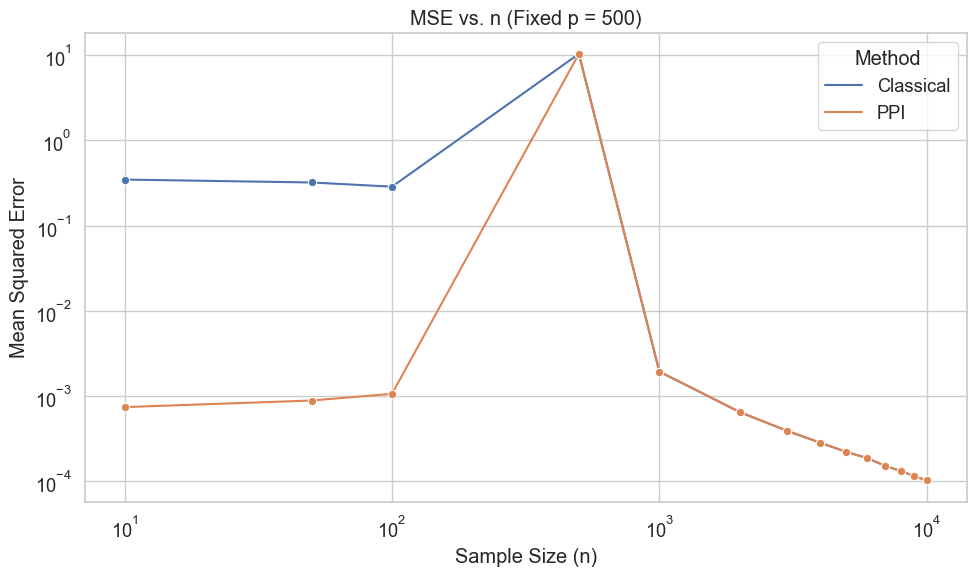

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df6 = pd.read_csv("experiment_results6_lam1.csv")
#df6 = df6[df6["n"]<=4000]  # Exclude p=5000 for clarity
df_avg = df6.groupby(["method", "n"])["error"].mean().reset_index()

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_avg, x="n", y="error", hue="method", marker="o")

plt.title("MSE vs. n (Fixed p = 500)")
plt.xlabel("Sample Size (n)")
plt.ylabel("Mean Squared Error") 
plt.yscale("log")
plt.xscale("log") 
plt.grid(True)
plt.legend(title="Method")
plt.tight_layout()
plt.show()


In [ ]:
n_total = 5000
p = 500
n = 1000
#p = 1000
#n = 500
num_trials = 50

results4 = []
_X_total, _Y_total, Yhat_total, theta, _ = generate_data(n_total, p, N_model=2000, std=1.0, random_state=1)

for trial in range(num_trials):
    print(f"Running experiments for trial {trial + 1}")
    idx = np.random.permutation(n_total)
    X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
    Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
    Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

    # PPI
    try:
        ppi_point = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=1.0)
        ppi_error = (ppi_point-theta)**2
        #print(f"PPI point estimate: {ppi_point.mean()}")
        #print(f"PPI error: {ppi_error.mean()}")

        results4.append({ 
            "method": "PPI", "p": p, "n": n, #"ratio": ratio, 
            "trial": trial, "std": 1.0,
            "theta": theta.mean(),
            "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
        })

    except Exception as e:
        print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
        break

    # Classical
    try:
        classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
        classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
        classical_error = (classical_mid - theta) ** 2

        results4.append({
            "method": "Classical", "p": p, "n": n, #"ratio": ratio, 
            "trial": trial, "std": 1.0,
            "theta": theta.mean(),
            "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
        })

    except Exception as e:
        print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
        break

df8 = pd.DataFrame(results4)
df8.to_csv("experiment_results8_lam1.csv", index=False)

Running experiments for trial 1
Running experiments for trial 2
Running experiments for trial 3
Running experiments for trial 4
Running experiments for trial 5
Running experiments for trial 6
Running experiments for trial 7
Running experiments for trial 8
Running experiments for trial 9
Running experiments for trial 10
Running experiments for trial 11
Running experiments for trial 12
Running experiments for trial 13
Running experiments for trial 14
Running experiments for trial 15
Running experiments for trial 16
Running experiments for trial 17
Running experiments for trial 18
Running experiments for trial 19
Running experiments for trial 20
Running experiments for trial 21
Running experiments for trial 22
Running experiments for trial 23
Running experiments for trial 24
Running experiments for trial 25
Running experiments for trial 26
Running experiments for trial 27
Running experiments for trial 28
Running experiments for trial 29
Running experiments for trial 30
Running experiments

In [ ]:
n_total = 5000
#n = p = 500
p = 1000
n = 500
num_trials = 50

results4 = []
_X_total, _Y_total, Yhat_total, theta, _ = generate_data(n_total, p, N_model=2000, std=1.0, random_state=1)

for trial in range(num_trials):
    print(f"Running experiments for trial {trial + 1}")
    idx = np.random.permutation(n_total)
    X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
    Y_labeled, Y_unlabeled = _Y_total[idx[:n]], _Y_total[idx[n:]]
    Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

    # PPI
    try:
        ppi_point = ppi_ols_pointestimate(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, lam=1.0)
        ppi_error = (ppi_point-theta)**2
        #print(f"PPI point estimate: {ppi_point.mean()}")
        #print(f"PPI error: {ppi_error.mean()}")

        results4.append({ 
            "method": "PPI", "p": p, "n": n, #"ratio": ratio, 
            "trial": trial, "std": 1.0,
            "theta": theta.mean(),
            "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
        })

    except Exception as e:
        print(f"[PPI ERROR] p={p}, trial={trial}: {e}")
        break

    # Classical
    try:
        classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
        classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
        classical_error = (classical_mid - theta) ** 2

        results4.append({
            "method": "Classical", "p": p, "n": n, #"ratio": ratio, 
            "trial": trial, "std": 1.0,
            "theta": theta.mean(),
            "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
        })

    except Exception as e:
        print(f"[Classical ERROR] p={p}, trial={trial}: {e}")
        break

df8 = pd.DataFrame(results4)
df8.to_csv("experiment_results8_lam1_phigh.csv", index=False)

Running experiments for trial 1
Running experiments for trial 2
Running experiments for trial 3
Running experiments for trial 4
Running experiments for trial 5
Running experiments for trial 6
Running experiments for trial 7
Running experiments for trial 8
Running experiments for trial 9
Running experiments for trial 10
Running experiments for trial 11
Running experiments for trial 12
Running experiments for trial 13
Running experiments for trial 14
Running experiments for trial 15
Running experiments for trial 16
Running experiments for trial 17
Running experiments for trial 18
Running experiments for trial 19
Running experiments for trial 20
Running experiments for trial 21
Running experiments for trial 22
Running experiments for trial 23
Running experiments for trial 24
Running experiments for trial 25
Running experiments for trial 26
Running experiments for trial 27
Running experiments for trial 28
Running experiments for trial 29
Running experiments for trial 30
Running experiments

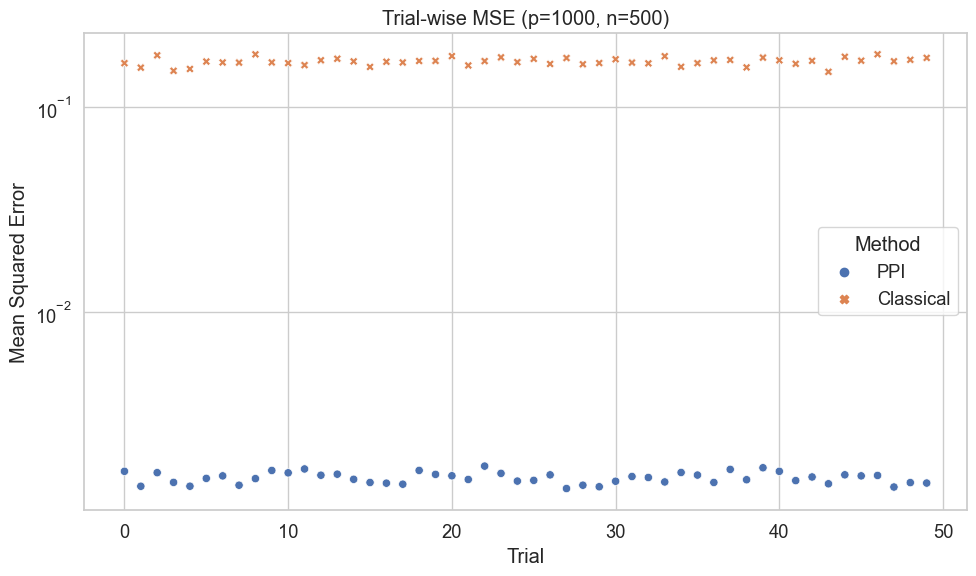

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df8 = pd.read_csv("experiment_results8_lam1_phigh.csv")

# 设置风格
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

# 散点图（按方法区分）
sns.scatterplot(data=df8, x="trial", y="error", hue="method", style="method")

# 可选：log y 轴
plt.yscale("log")

plt.title("Trial-wise MSE (p=1000, n=500)")
plt.xlabel("Trial")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.legend(title="Method")
plt.tight_layout()
plt.show()


In [ ]:
df4 = pd.read_csv("experiment_results4.csv")

# Plotting

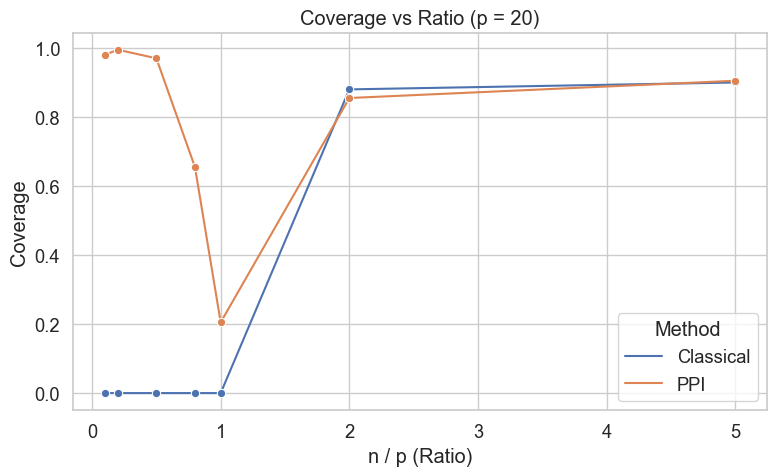

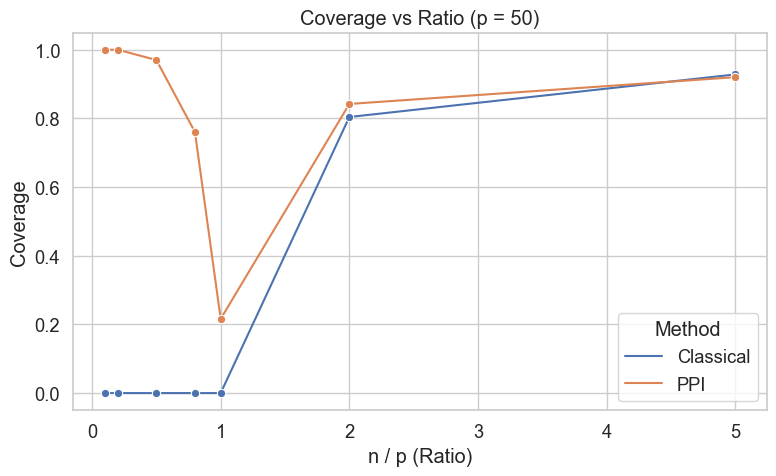

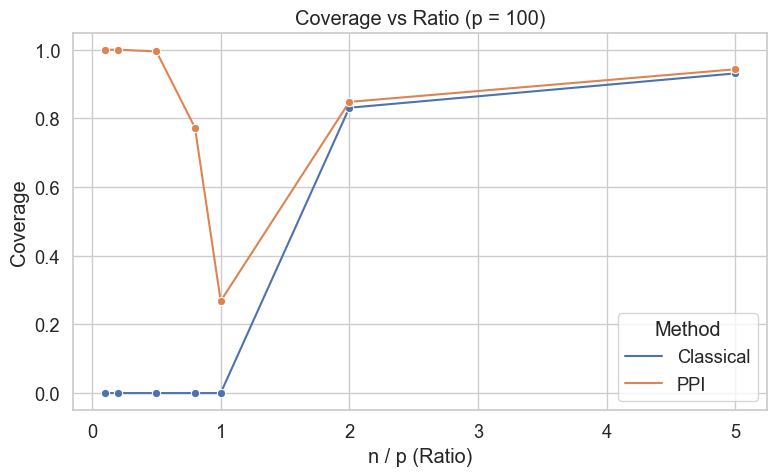

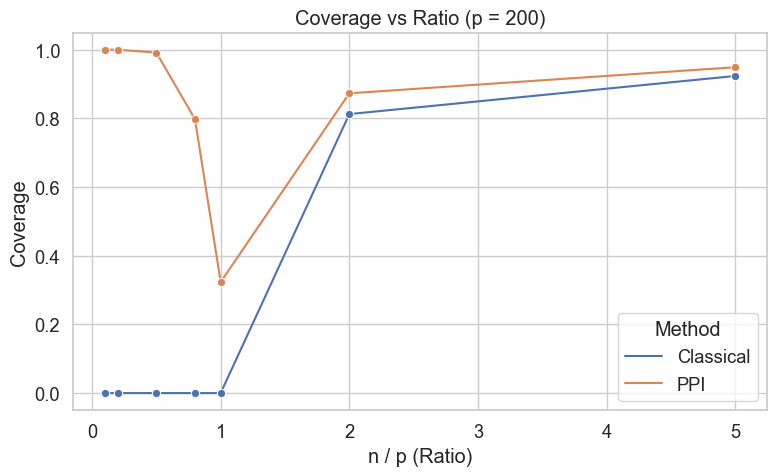

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df4[df4["method"] != "Imputation"]
#df = df[df["ratio"] != 1]

df_avg = df.groupby(["method", "p", "ratio"]).agg({
    "coverage": "mean"
}).reset_index()

sns.set(style="whitegrid", font_scale=1.2)

for p_val in sorted(df_avg["p"].unique()):
    subset = df_avg[df_avg["p"] == p_val]
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=subset, x="ratio", y="coverage", hue="method", marker="o")
    plt.title(f"Coverage vs Ratio (p = {p_val})")
    plt.xlabel("n / p (Ratio)")
    plt.ylabel("Coverage")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


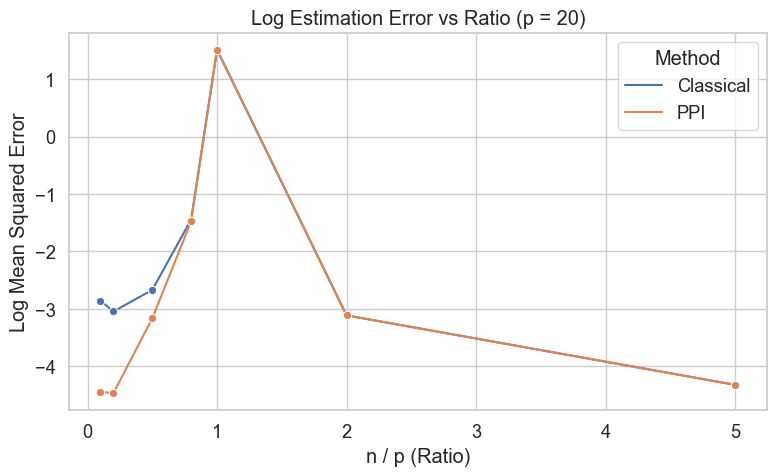

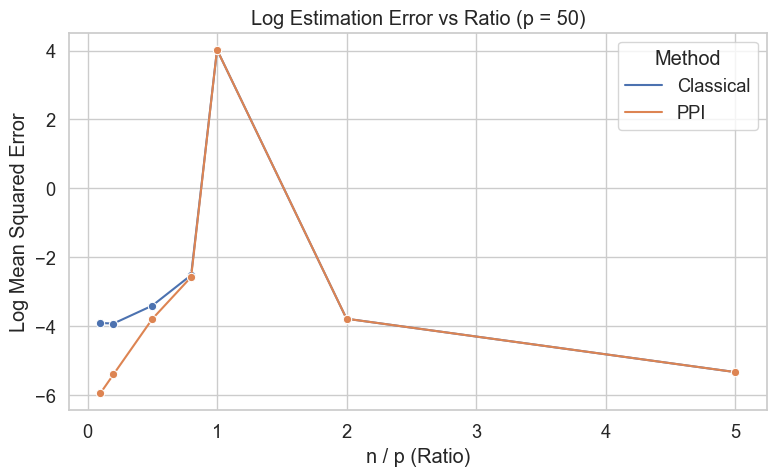

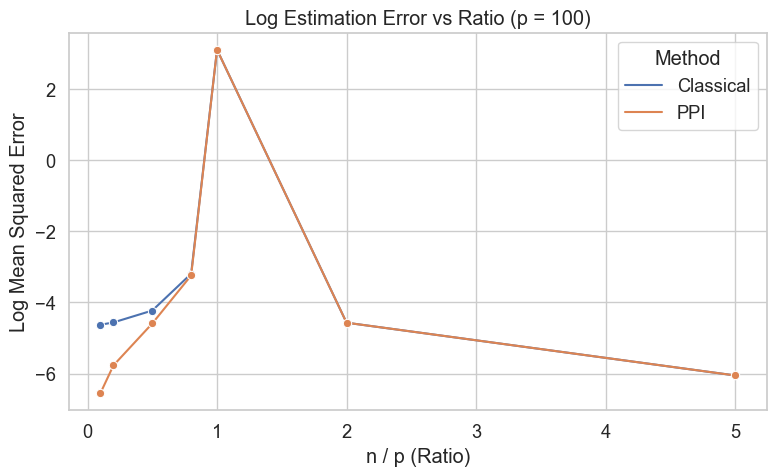

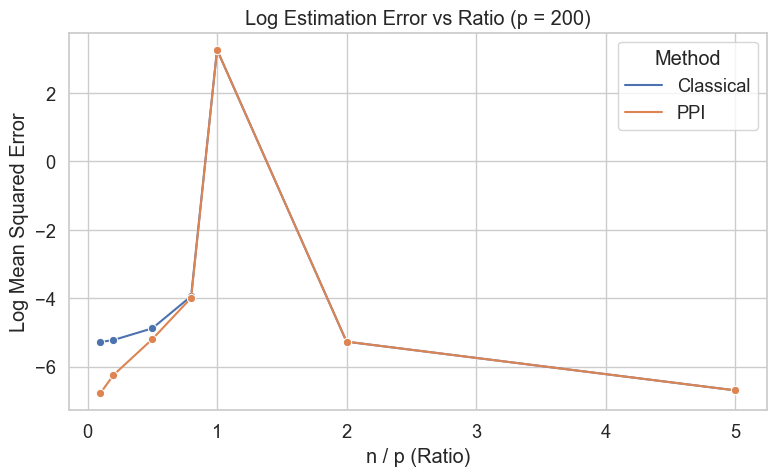

In [17]:
df_avg = df.groupby(["method", "p", "ratio"]).agg({
    "error": "mean"
}).reset_index()

sns.set(style="whitegrid", font_scale=1.2)

for p_val in sorted(df_avg["p"].unique()):
    subset = df_avg[df_avg["p"] == p_val]
    plt.figure(figsize=(8, 5))
    #sns.lineplot(data=subset, x="ratio", y="error", hue="method", marker="o")
    sns.lineplot(data=subset, x="ratio", y=np.log(subset["error"]), hue="method", marker="o")
    plt.title(f"Log Estimation Error vs Ratio (p = {p_val})")
    plt.xlabel("n / p (Ratio)")
    plt.ylabel("Log Mean Squared Error")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


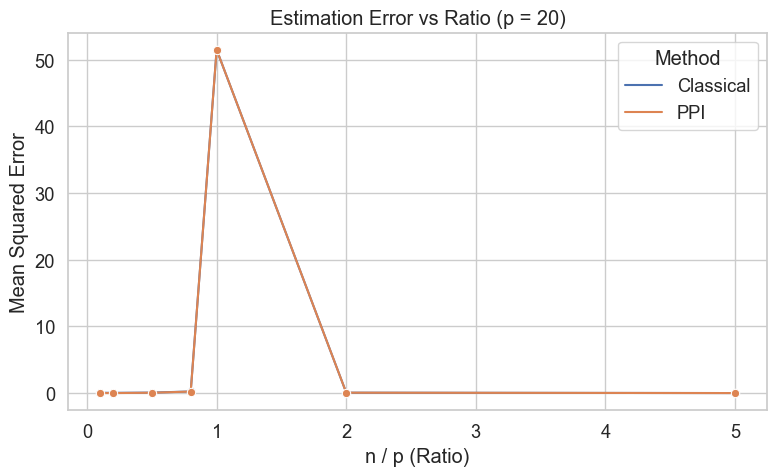

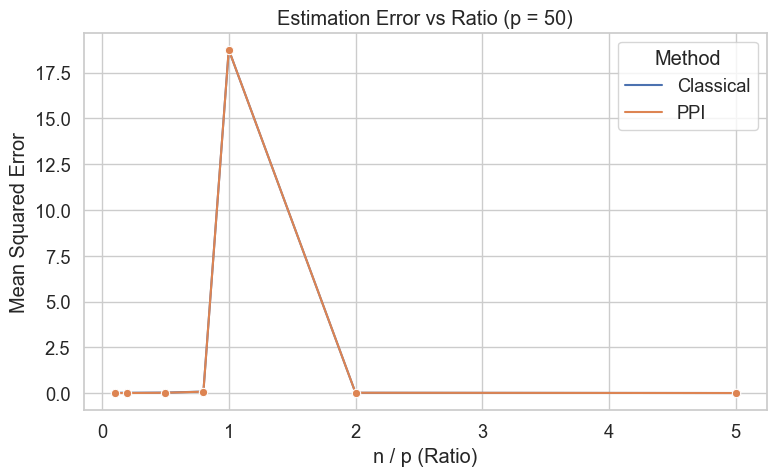

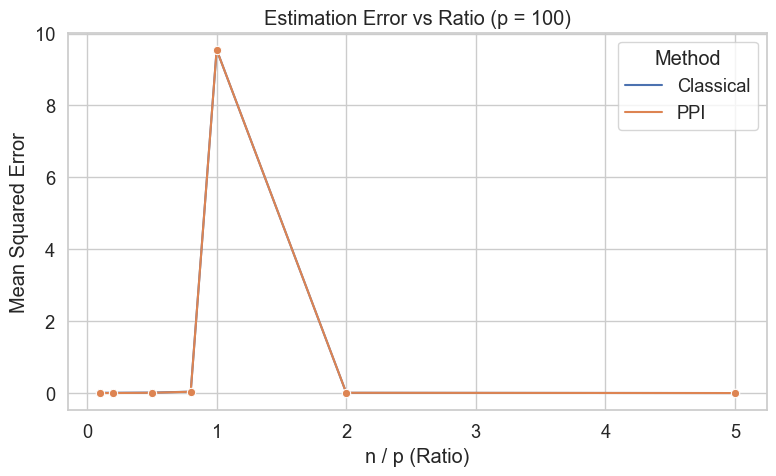

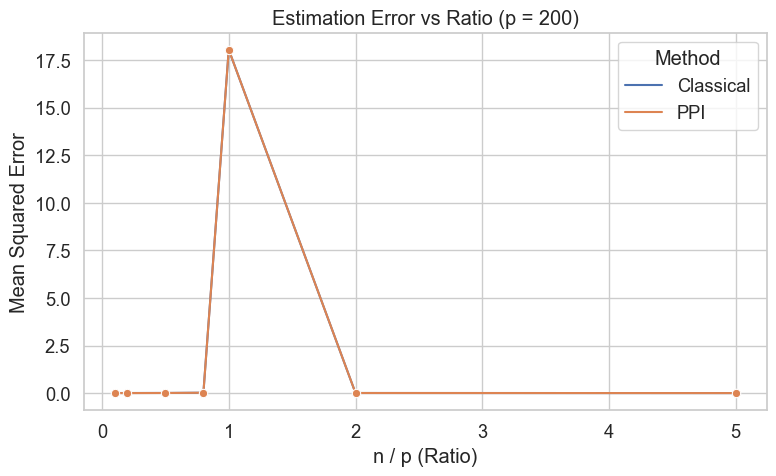

In [21]:
df_avg = df.groupby(["method", "p", "ratio"]).agg({
    "error": "mean"
}).reset_index()

sns.set(style="whitegrid", font_scale=1.2)

for p_val in sorted(df_avg["p"].unique()):
    subset = df_avg[df_avg["p"] == p_val]
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=subset, x="ratio", y="error", hue="method", marker="o")
    plt.title(f"Estimation Error vs Ratio (p = {p_val})")
    plt.xlabel("n / p (Ratio)")
    plt.ylabel("Mean Squared Error")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


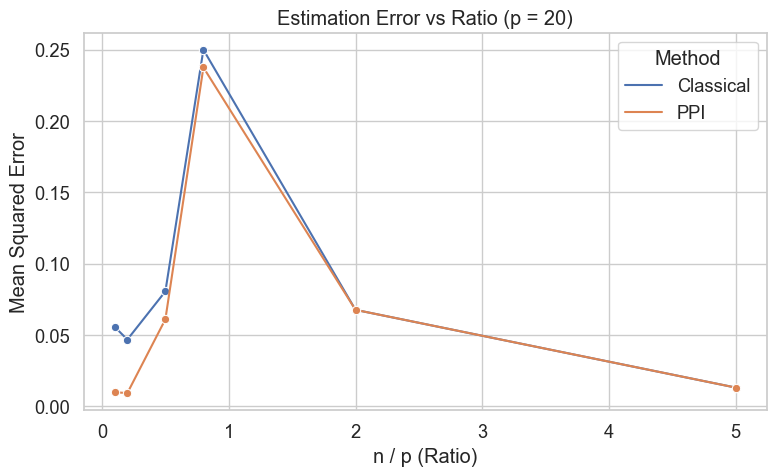

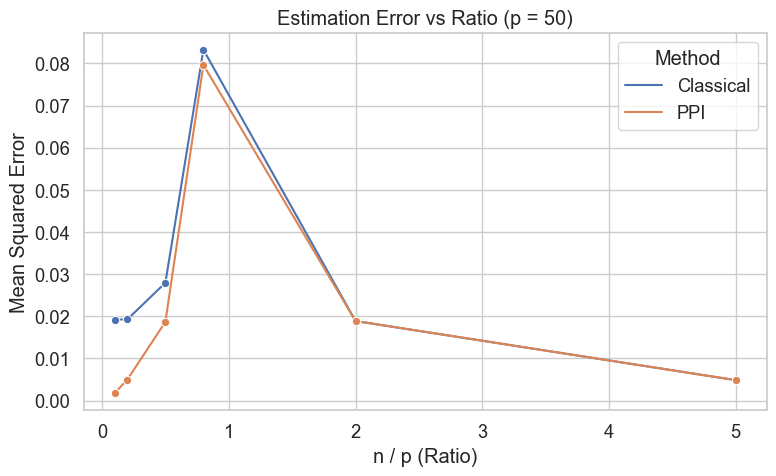

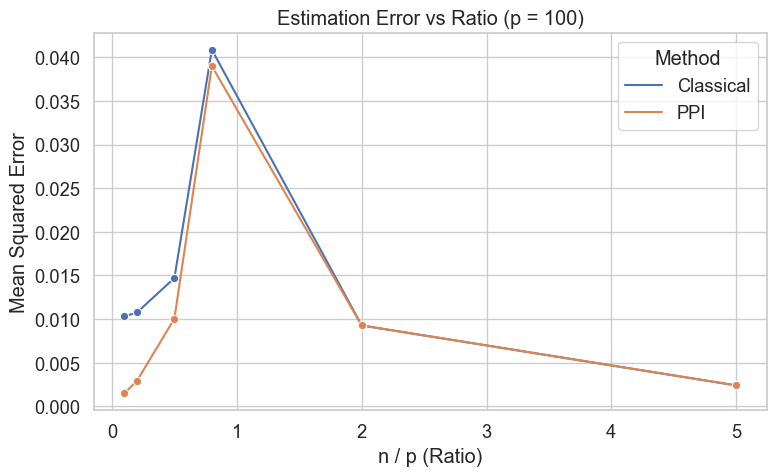

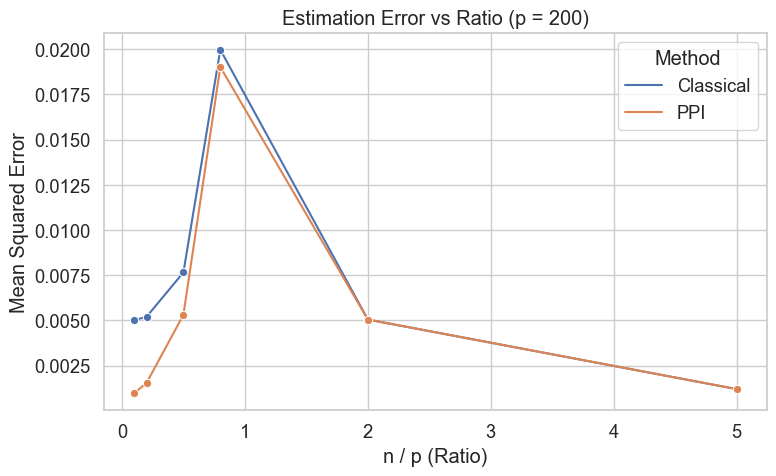

In [22]:
df_avg = df[df["ratio"] != 1].groupby(["method", "p", "ratio"]).agg({
    "error": "mean"
}).reset_index()

sns.set(style="whitegrid", font_scale=1.2)

for p_val in sorted(df_avg["p"].unique()):
    subset = df_avg[df_avg["p"] == p_val]
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=subset, x="ratio", y="error", hue="method", marker="o")
    plt.title(f"Estimation Error vs Ratio (p = {p_val})")
    plt.xlabel("n / p (Ratio)")
    plt.ylabel("Mean Squared Error")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
